In [10]:
import pandas as pd
import ast
from mlxtend.frequent_patterns import association_rules

# -----------------------
# 1️⃣ 讀取 FP-Growth 結果 CSV
# -----------------------
frequent_itemsets = pd.read_csv(
    "D:\\es\\frequent_itemset\\frequent_itemsets_95threshold_pre30y.csv"
)

# -----------------------
# 2️⃣ 將 itemsets 欄位轉成 Python set
# -----------------------
def to_set(item):
    if isinstance(item, str):
        try:
            return set(ast.literal_eval(item))
        except Exception:
            return set()
    return set(item)

frequent_itemsets['itemsets'] = frequent_itemsets['itemset'].apply(to_set)

# -----------------------
# 3️⃣ 確保 DataFrame 只保留 association_rules 需要的欄位
# -----------------------
freq_items = frequent_itemsets[['itemsets', 'support']]

# -----------------------
# 4️⃣ 生成關聯規則
# -----------------------
rules = association_rules(freq_items, metric="confidence", min_threshold=0.50)

# -----------------------
# 5️⃣ 查看結果
# -----------------------
print("\n關聯規則（置信度 > 0.20）：")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])



關聯規則（置信度 > 0.20）：
         antecedents       consequents   support  confidence      lift
0    (27.625_72.375)   (27.625_67.375)  0.131313    0.684211  3.870677
1    (27.625_67.375)   (27.625_72.375)  0.131313    0.742857  3.870677
2    (22.625_77.375)   (27.625_72.375)  0.126263    0.781250  4.070724
3    (27.625_72.375)   (22.625_77.375)  0.126263    0.657895  4.070724
4   (67.625_167.375)  (67.625_172.375)  0.121212    0.888889  5.677419
5   (67.625_172.375)  (67.625_167.375)  0.121212    0.774194  5.677419
6    (32.625_77.375)   (27.625_77.375)  0.111111    0.666667  5.500000
7    (27.625_77.375)   (32.625_77.375)  0.111111    0.916667  5.500000
8    (32.625_72.375)   (32.625_77.375)  0.111111    0.594595  3.567568
9    (32.625_77.375)   (32.625_72.375)  0.111111    0.666667  3.567568
10   (52.625_77.375)   (52.625_82.375)  0.101010    0.606061  4.800000
11   (52.625_82.375)   (52.625_77.375)  0.101010    0.800000  4.800000
12   (32.625_97.375)   (32.625_92.375)  0.101010    0.7142

In [11]:
import numpy as np
from tqdm import tqdm

# 假設 rules['antecedents'] 和 rules['consequents'] 是 set of "lat_lon" 字串

def compute_center_with_progress(sets_series):
    centers = []
    for coords_set in tqdm(sets_series, total=len(sets_series), desc="Computing centers"):
        if not coords_set:
            centers.append((np.nan, np.nan))
            continue
        coords_array = np.array([list(map(float, i.split('_'))) for i in coords_set])
        lat_mean = np.mean(coords_array[:, 0])
        lon_mean = np.mean(coords_array[:, 1])
        centers.append((lat_mean, lon_mean))
    return zip(*centers)

# 計算 antecedents 中心
rules['ante_lat'], rules['ante_lon'] = compute_center_with_progress(rules['antecedents'])

# 計算 consequents 中心
rules['cons_lat'], rules['cons_lon'] = compute_center_with_progress(rules['consequents'])


Computing centers: 100%|██████████| 14/14 [00:00<?, ?it/s]


In [12]:
from tqdm import tqdm

# 確保 tqdm 可以和 pandas 互動
tqdm.pandas(desc="Parsing antecedent coords")
rules['ante_coords'] = rules['antecedents'].progress_apply(
    lambda coord_set: [tuple(map(float, s.split('_'))) for s in coord_set]
)

tqdm.pandas(desc="Parsing consequent coords")
rules['cons_coords'] = rules['consequents'].progress_apply(
    lambda coord_set: [tuple(map(float, s.split('_'))) for s in coord_set]
)


Parsing consequent coords: 100%|██████████| 14/14 [00:00<?, ?it/s]


In [41]:
import pandas as pd
from tqdm import tqdm

# 假設 rules 已經計算好 ante_lat, ante_lon, cons_lat, cons_lon, ante_coords, cons_coords

# 逐行寫入 CSV 並顯示進度
with open("D:\\es\\association_rule\\association_rules_with_centers_post30y.csv", "w", encoding="utf-8") as f:
    # 寫入標題
    f.write(",".join(rules.columns) + "\n")
    
    # 寫入每一行
    for i in tqdm(range(len(rules)), desc="Saving CSV"):
        row = rules.iloc[i]
        row_str = ",".join(str(row[col]) for col in rules.columns)
        f.write(row_str + "\n")

print("✅ 儲存完成")

Saving CSV: 100%|██████████| 69949416/69949416 [1:15:19<00:00, 15477.48it/s]


✅ 儲存完成


In [ ]:
import pandas as pd
import csv
import ast

rules = pd.read_csv(
    "D:\\es\\association_rule\\association_rules_with_centers_post30y.csv",
    quoting=csv.QUOTE_NONE,     # 不要自動幫你處理引號
    escapechar="\\",            # 如果有特殊符號，用反斜線跳脫
    engine="python"             # 用 Python parser，比 C parser 寬鬆
)

# 把文字轉回 list of tuple
# tqdm 包裝，顯示進度條
rules['ante_coords'] = [
    ast.literal_eval(x) if isinstance(x, str) else [] 
    for x in tqdm(rules['ante_coords'], desc="Parsing ante_coords")
]

rules['cons_coords'] = [
    ast.literal_eval(x) if isinstance(x, str) else [] 
    for x in tqdm(rules['cons_coords'], desc="Parsing cons_coords")
]

In [ ]:
# 中心點
target_lat = 32.625
target_lon = 22.375
range_deg = 5  # ±5度

# 定義範圍
lat_range = (target_lat - range_deg, target_lat + range_deg)
lon_range = (target_lon - range_deg, target_lon + range_deg)

# 定義函數：只要 ante_coords 中有一個點落在 ±5 度內，就算符合
def in_latlon_range(coord_list):
    return any(
        lat_range[0] <= lat <= lat_range[1] and lon_range[0] <= lon <= lon_range[1]
        for lat, lon in coord_list
    )

# 篩選規則
nearby_rules = rules[rules['ante_coords'].apply(in_latlon_range)]

In [23]:
# 你關注的經緯度列表
target_coords = [
    # (27.625, 67.375),
    # (27.625, 72.375),
    # (22.625, 77.375),
    # (27.625, 72.375),
    # (67.625, 172.375),
    # (67.625, 167.375),
    # (32.625, 77.375),
    # (27.625, 77.375),
    # (32.625, 77.375),
    # (32.625, 72.375),
    (52.625, 77.375),
    # (52.625, 82.375),
    # (32.625, 92.375),
    # (32.625, 97.375)
]

target_set = set(target_coords)  # 為了加快查找效率

# 定義函數：只要 ante_coords 中有一個在 target_set 就算符合
def contains_target(coord_list):
    return any((lat, lon) in target_set for lat, lon in coord_list)

# 篩選 ante_coords 中包含目標經緯度的規則
nearby_rules = rules[rules['ante_coords'].apply(contains_target)]

In [24]:
print(f"找到 {len(nearby_rules)} 條規則，antecedents 中心在緯度約 50、經度約 60 的範圍內：")
print(nearby_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

找到 1 條規則，antecedents 中心在緯度約 50、經度約 60 的範圍內：
        antecedents      consequents  support  confidence  lift
10  (52.625_77.375)  (52.625_82.375)  0.10101    0.606061   4.8


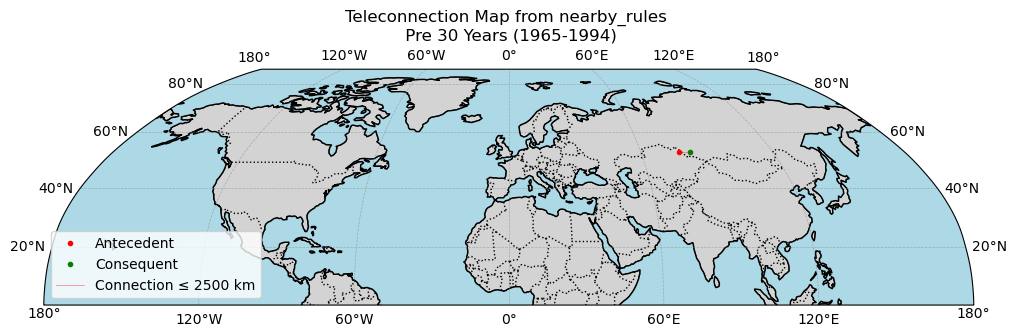

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os

# haversine formula 計算球面距離 (單位: km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 地球半徑 km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return R * (2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)))

# 1. 創建地圖
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# 繪製陸地、海洋、邊界
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

# 經緯網格線
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# 2. 繪製資料
first_ante, first_cons, first_long, first_short = True, True, True, True
for idx, row in nearby_rules.iterrows():
    ante_coords = row['ante_coords']  # list of tuples [(lat, lon), ...]
    cons_coords = row['cons_coords']  # list of tuples [(lat, lon), ...]

    if isinstance(ante_coords, list) and isinstance(cons_coords, list):
        for (lat1, lon1) in ante_coords:
            # Antecedent
            ax.plot(lon1, lat1, 'ro', markersize=3,
                    transform=ccrs.PlateCarree(),
                    label='Antecedent' if first_ante else "")
            first_ante = False

            for (lat2, lon2) in cons_coords:
                # Consequent
                ax.plot(lon2, lat2, 'go', markersize=3,
                        transform=ccrs.PlateCarree(),
                        label='Consequent' if first_cons else "")
                first_cons = False

                # 計算距離
                dist_km = haversine(lat1, lon1, lat2, lon2)
                if dist_km > 2500:
                    color = 'blue'
                    label = 'Connection > 2500 km' if first_long else ""
                    first_long = False
                else:
                    color = 'red'
                    label = 'Connection ≤ 2500 km' if first_short else ""
                    first_short = False

                ax.plot([lon1, lon2], [lat1, lat2],
                        color=color, linewidth=0.5, alpha=0.5,
                        transform=ccrs.PlateCarree(),
                        label=label)

plt.title('Teleconnection Map from nearby_rules \n Pre 30 Years (1965-1994)')
ax.legend(loc='lower left')

# 指定輸出資料夾
out_dir = "D:\\es\\association_rule"

plt.savefig(
    os.path.join(out_dir, 'pre30y(52.625, 77.375)_dis.png')
    , dpi=300, bbox_inches='tight')
plt.show()
plt.close()

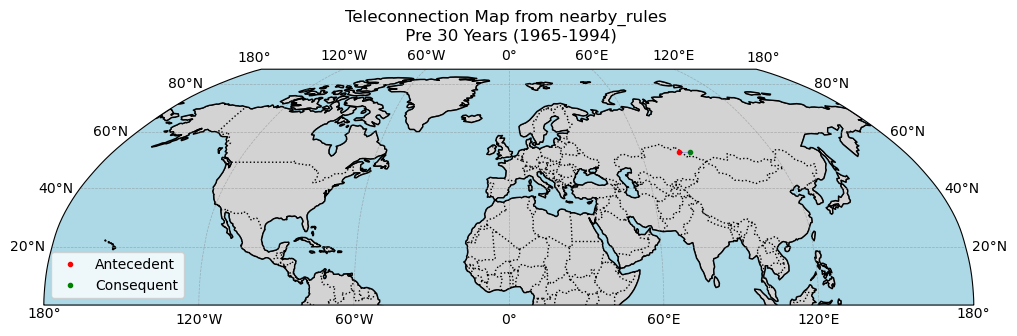

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. 創建地圖
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# 標籤控制
ante_plotted = False
cons_plotted = False

# 2. 迭代 nearby_rules 繪圖
for idx, row in nearby_rules.iterrows():
    ante_coords = row['ante_coords']
    cons_coords = row['cons_coords']
    
    if isinstance(ante_coords, list) and isinstance(cons_coords, list):
        for (lat1, lon1) in ante_coords:
            # 標記前事件座標
            label = 'Antecedent' if not ante_plotted else None
            ax.plot(lon1, lat1, 'ro', markersize=3, transform=ccrs.PlateCarree(), label=label)
            ante_plotted = True
            
            for (lat2, lon2) in cons_coords:
                # 標記後事件座標
                label = 'Consequent' if not cons_plotted else None
                ax.plot(lon2, lat2, 'go', markersize=3, transform=ccrs.PlateCarree(), label=label)
                cons_plotted = True
                
                # 繪製連線
                ax.plot([lon1, lon2], [lat1, lat2],
                        color='blue', linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree())

# 顯示 legend，只會顯示一次
ax.legend(loc='lower left')
plt.title('Teleconnection Map from nearby_rules \n Pre 30 Years (1965-1994)')
# 指定輸出資料夾
out_dir = "D:\\es\\association_rule"

plt.savefig(
    os.path.join(out_dir, 'pre30y(52.625, 77.375).png')
    , dpi=300, bbox_inches='tight')
plt.show()
